In [1]:
from integr import  *
import pytesseract
import matplotlib.pyplot as plt 
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import random
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBClassifier

In [102]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,14)

In [2]:
def to_image( array ) :
    return cv2.cvtColor(array, cv2.COLOR_BGR2RGB)

In [3]:
class BboxLabel:
    def __init__(self, label, x0, y0, w, h):
        self.h = h
        self.w = w
        self.y0 = y0
        self.x0 = x0
        self.label = label

    @classmethod
    def from_str(cls, label_str):
        split = label_str.strip().split(" ")
        label, x0, y0, w, h = split
        return cls(int(label), float(x0), float(y0), float(w), float(h))

    def bbox(self, h, w):
        x0 = int((self.x0 - self.w / 2) * w)
        y0 = int((self.y0 - self.h / 2) * h)
        x1 = int((self.x0 + self.w / 2) * w)
        y1 = int((self.y0 + self.h / 2) * h)
        return x0, y0, x1, y1

In [4]:
def get_grount_truth(path_label, path_image):
    with open(path_label) as f:
        labels = f.read()
    labels = labels.split('\n')
    img_label = cv2.imread(path_image)

    true_label = {}
    for ind, i in enumerate(labels[:-1]):
        q = BboxLabel.from_str(i)
        x, y, w, h = q.bbox(img_label.shape[0], img_label.shape[1])
        label = q.label

        true_label[ind] = (x, y, w - x, h - y, label)
    return true_label
net=create_craft()


In [5]:
def euclide_words(x_mean,y_mean,text_mean):
     return np.sqrt((text_mean[0] - x_mean) **2 + (text_mean[1] - y_mean)**2)

In [6]:
def inter_words(img,rect,cord_words):
    wordss=''
    amount_words=0
    shape_img=img.shape[:2]
    mask_1 = np.zeros(shape_img, dtype="uint8")
    cv2.rectangle(mask_1, (rect[0], rect[1]),
                          (rect[0] + rect[2], rect[1] + rect[3]), 1, -1)
    x,y,w,h=rect[:4]
    color=bincount_app(img[y:y + h, x:x + w])
    for coord,word in cord_words.items():
        if word==None:
            continue
        mask_2 = np.zeros(img.shape[:2], dtype="uint8")
        cv2.rectangle(mask_2, (coord[0], coord[1]),
                              (coord[0] + coord[2], coord[1] + coord[3]), 1, -1)
        
        if np.sum(cv2.bitwise_or(mask_1, mask_2))==np.sum((mask_1)):
            amount_words+=len(word.split(' '))
            wordss=wordss+' '+word+' '
    if amount_words==0:
        wordss=''
        min_length=1000
        for coord,word in cord_words.items():
            length=euclide_words(rect[0]+rect[2]/2,rect[1]+rect[1]/2,coord[4])
            
            if length<min_length:
                min_length=length
                wordss=word
        return amount_words, min_length,0,color,wordss
    return amount_words, 0,1,color,wordss
    

In [7]:
def bincount_app(img):
    img2d=img.reshape(-1,img.shape[-1])
  
    col_range=(256,256,256)
    img1d=np.ravel_multi_index(img2d.T,col_range)
    return np.unravel_index(np.bincount(img1d).argmax(),col_range)
    

In [90]:
def get_words(text_cords,img):
    dict_detect_words={}
    for v in text_cords:
        x,y,w,h,mean_text=v
        qwe=pytesseract.image_to_string(
                        img[y:y + h, x:x + w],
                        config='').replace('\n\x0c','').replace('\x0c','')
        dict_detect_words[(x,y,w,h,mean_text)]=qwe if len(qwe)>1 else None
    return dict_detect_words

In [322]:
def get_df(img_path, predict_dict, label_dict,words,test=False):
    img = cv2.imread(img_path)
    shape_img=img.shape[:2]
    df_all=[]
    indexs = []
    for ind, rect in predict_dict.items():
        df_intersec = {}
        coord = rect
        mask_1 = np.zeros(img.shape[:2], dtype="uint8")
        cv2.rectangle(mask_1, (coord[0], coord[1]), (coord[0] + coord[2], coord[1] + coord[3]), 1, -1)
        
        
        for ind2, rect_2 in label_dict.items():
            mask_2 = np.zeros(img.shape[:2], dtype="uint8")
            coord_label = rect_2
            cv2.rectangle(mask_2, (coord_label[0], coord_label[1]),
                          (coord_label[0] + coord_label[2], coord_label[1] + coord_label[3]), 1, -1)
            intersec = get_intersec(mask_1, mask_2)
            if intersec > 0.75:
                if ind not in indexs:
                    if test:
                       
                        df_intersec['ind'] = int(ind)
                    amount,length,in_word,color,wordss=inter_words(img,coord,words)      
                    df_intersec['amount_words'] = amount
                    df_intersec['lenght_to_word']=length
                    df_intersec['has_words_in']=in_word
                    df_intersec['area_rect']=(coord[2]*coord[3])
                    df_intersec['b']=color[0]
                    df_intersec['g']=color[1]
                    df_intersec['r']=color[2]
                    df_intersec['img_name']=img_path
                    df_intersec['words']=wordss
                    df_intersec['target']=coord_label[4]
                    
                    
                    indexs.append(ind)
                    df_all.append(df_intersec)
                    break
                    
    for i,rect  in predict_dict.items():
     
        if i not in indexs:
            
                    
            df_intersec = {}
            amount,length,in_word,color,wordss=inter_words(img,rect,words) 
            if test:
                    df_intersec['ind'] = int(i)
            df_intersec['amount_words'] = amount
            df_intersec['lenght_to_word']=length
            df_intersec['has_words_in']=in_word
            df_intersec['area_rect']=(rect[2]*rect[3])
            df_intersec['b']=color[0]
            df_intersec['g']=color[1]
            df_intersec['r']=color[2]
            df_intersec['img_name']=img_path
            df_intersec['words']=wordss
            df_intersec['target']=6
            df_all.append(df_intersec)
            

        
    return df_all

In [220]:
def metric_class(yv,pred,sum=True):
    class_0=0
    class_1=0
    class_4=0
    class_6=0

    for i,q in zip(yv,pred):
        if i==0 and q==0:
            class_0+=1
        if i==1 and q==1:
            class_1+=1
        if i==4 and q==4:
            class_4+=1    
        if i==6 and q==6:
            class_6+=1     
    if sum:
        return (class_6/len(yv[yv==6]))*0.1+(class_0/len(yv[yv==0]))*0.3+(class_1/len(yv[yv==1]))*0.3+(class_4/len(yv[yv==4]))*0.3
    else:
        return class_6/len(yv[yv==6]),(class_0/len(yv[yv==0])),(class_1/len(yv[yv==1])),(class_4/len(yv[yv==4])),class_6/len(pred[pred==6]),(class_0/len(pred[pred==0])),(class_1/len(pred[pred==1])),(class_4/len(pred[pred==4]))

In [325]:
def get_predict(img_path, rect_dict, g_t,words):
    df_sample=get_df(img_path, rect_dict, g_t,words,test=True)
    test_df=pd.DataFrame(df_sample)
    test_df=test_df.set_index('ind')
    testx,testy=test_df.drop(['target','img_name','words'],axis=1),test_df.target
    pred_test=model.predict(testx)
    return test_df,pred_test

In [288]:
def del_draw_buttons(df,rect_dict,pred,img):
    font = cv2.FONT_HERSHEY_PLAIN  
  

    org = (50, 50)


    fontScale = 1

    
    color=(0,0,255)
    color_button = (0, 0,0)
    color_boxfor_text = (124,252,0) 
    
    thickness = 2
    for i,pred in zip(df.index,pred):
        if pred==6:

            del rect_dict[i]
        if pred==0:
            org=rect_dict[i][:2]   
            image = cv2.putText(img, 'Button', org, font, 
                           fontScale, color, thickness, cv2.LINE_AA)
        if pred==1:
            org=rect_dict[i][:2]   
            image = cv2.putText(img, 'BoxForText', org, font, 
                           fontScale, color_button, thickness, cv2.LINE_AA)
        if pred==4:
            org=rect_dict[i][:2]   
            image = cv2.putText(img, 'CheckBox', org, font, 
                           fontScale, color_boxfor_text, thickness, cv2.LINE_AA)    
    return rect_dict

In [41]:
net=create_craft()

In [40]:
df_samples=[]

In [60]:
for sample in tqdm(list(set([i.split('.')[0] for i in os.listdir('selenium') if i.split('.')[0]!='classes'])), position=0, leave=True):
    pth_img='selenium/'+sample+'.png'
    pth_label='selenium/'+sample+'.txt'
    img=cv2.imread(pth_img)
    labels = detect_save_text(pth_img, net)
 
    without_text, mean_text,text_cords = preproc_mean_text(labels, img)
    contours = get_contours(without_text)  
    rect_dict, line_dict = get_rect_line(contours)    
    for ind, line in line_dict.items():
       
            if line.ravel()[:2][1]>30:
                x, y, w, h = line.ravel()[:2][0], line.ravel()[:2][1]-30, line.ravel()[-2:][0] - line.ravel()[:2][0], 30
                if w>0 and h>0:
                    rect_dict[ind + 200] = (x, y, w, h)
    rect_dict = filter_rect(img, rect_dict, mean_text, threshold_inter=0.5, distance_text=300)
    g_t = get_grount_truth(pth_label, pth_img)
    words=get_words(text_cords,img)                          
    df_sample=get_df(pth_img, rect_dict, g_t,words)
    df_samples=df_samples+df_sample                          

 13%|█▎        | 39/300 [43:52<4:42:42, 64.99s/it]

KeyboardInterrupt: 

In [345]:
img_test_path='selenium/15_0.png'
txt_test_path='selenium/15_0.png'.split('.')[0]+'.txt'

In [346]:
img=cv2.imread(img_test_path)
img2=cv2.imread(img_test_path)
img3=cv2.imread(img_test_path)
img_test=cv2.imread(img_test_path)
labels = detect_save_text(img_test_path, net)

without_text, mean_text,text_cords = preproc_mean_text(labels, img_test)
contours = get_contours(without_text)  
rect_dict, line_dict = get_rect_line(contours)    
for ind, line in line_dict.items():

        if line.ravel()[:2][1]>30:
            x, y, w, h = line.ravel()[:2][0], line.ravel()[:2][1]-30, line.ravel()[-2:][0] - line.ravel()[:2][0], 30
            if w>0 and h>0:
                rect_dict[ind + 200] = (x, y, w, h)
rect_dict = filter_rect(img_test, rect_dict, mean_text, threshold_inter=0.5, distance_text=300)
g_t = get_grount_truth(txt_test_path, img_test_path)
words=get_words(text_cords,img_test)


In [347]:
test_df,pred_test=get_predict(img_test_path, rect_dict, g_t,words)

In [348]:
rect_dict=del_draw_buttons(test_df,rect_dict,pred_test,img3)

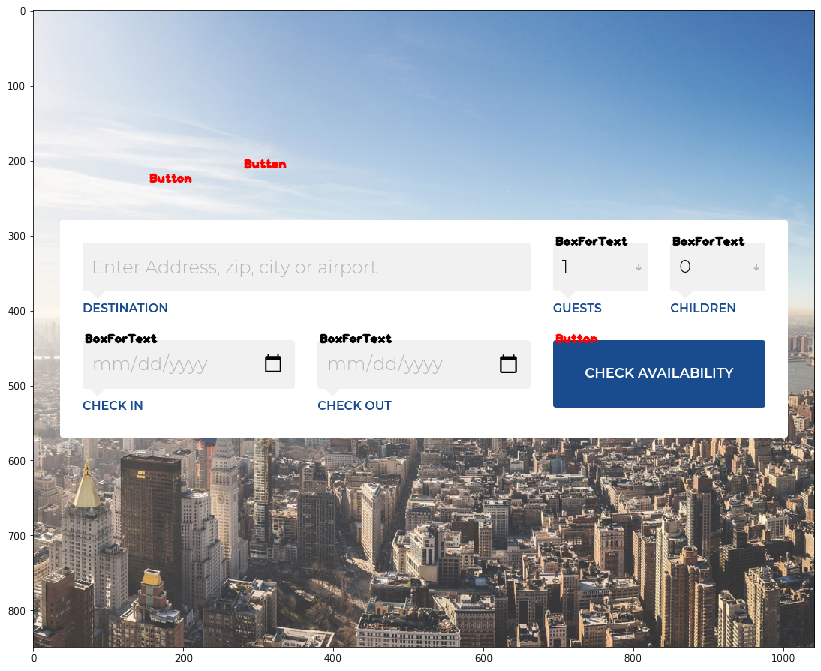

In [349]:
plt.imshow(to_image(img3))

In [353]:
df_test=pd.DataFrame(df_samples)
uni_samples=np.unique(df_test.img_name)
random.shuffle(uni_samples)

In [354]:
ind_80=int(len(uni_samples)*0.8)
train_df=df_test[df_test.img_name.isin(uni_samples[:ind_80])]
test_df=df_test[df_test.img_name.isin(uni_samples[ind_80:])]

x,y=train_df.drop(['target','img_name','wrods'],axis=1),train_df.target

xte,yte=test_df.drop(['target','img_name','wrods'],axis=1),test_df.target

In [355]:
folds_split=StratifiedKFold(5)

In [356]:
tr_val_ind=[]
for i in folds_split.split(x,y):

    tr_val_ind.append(i)

In [360]:
parameters = {'learning_rate': np.linspace(0.01,0.15,5), 'max_depth': list(range(4,9)), 'n_estimators':list(range(200,600,100)),'min_child_weight': [16],
             'colsample_bytree': [0.8],'reg_lambda': [4]}

In [361]:
params=ParameterGrid(parameters)

In [136]:
dic_par={}
for par in  params:
    list_metr=[]
    for i in tr_val_ind:
        xval=x.loc[np.r_[i[1]]]
        yval=y[np.r_[i[1]]]
        weight=[10  if i in[0,1,4] else 0.1  for i in y[np.r_[i[0]]] ]
        model = XGBClassifier(objective='multi:softmax',seed=42,**par,n_jobs=-1)
        model.fit(x.loc[np.r_[i[0]]], y[np.r_[i[0]]],sample_weight=weight)
        pred=model.predict(x.loc[np.r_[i[1]]])
        metr=metric_class(y[np.r_[i[1]]],pred)
        list_metr.append(metr)
    
    dic_par[np.mean(list_metr)]=par

In [ ]:
best_param=dic_par[np.max(lsit(dic_par.keys()))]

In [71]:
weight=[10  if i in[0,1,4] else 0.1  for i in y ]
model = XGBClassifier(objective='multi:softmax',seed=42,**best_param,n_jobs=-1)
model.fit(x, y,sample_weight=weight)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=16, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=4, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)